# Exploring the Intersection of Teen Pregnancy and Education Outcomes

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This analysis aims to understand whether, among different countries, higher rates of teen pregnancy or birth are associated with lower educational attainment (and vice versa). After cleaning and merging the data, the following six questions will be explored:
<ol>
    <li>How do teen fertility rates vary across countries?</li>
    <li>How do teen fertility rates vary across regions?</li>
    <li>How do teen fertility rates vary by country income?</li>
    <li>Do countries with higher rates of teen fertility also tend to have lower literacy rates for girls?</li>
    <li>Do countries with higher rates of teen fertility also tend to have lower school completion rates for girls?</li>
    <li>And, how have teen fertility rates changed over time? Where are they increasing?</li>
</ol>

The following variables are used in this analysis:
<ul>
    <li><strong>Teen fertility rate</strong>, meaning the number of births per 1,000 women ages 14-19, is the primary variable being analyzed. Source: Gapminder, compiled from various sources.</li>
    <li><strong>The percent of girls completing primary school.</strong> Source: World Bank.</li>
    <li><strong>Literacy rate among females ages 15-24.</strong> Source: UNESCO Institute for Statistics.</li>
    <li><strong>A country's <i>income group</i> and <i>region</i></strong> are also considered in relation to the above variables. These are provided by the World Bank, accompanying the download of the primary school completion dataset above (available <a href="https://data.worldbank.org/indicator/SE.PRM.CMPT.FE.ZS">here</a>).</li>
</ul>

All datasets used in this analysis were obtained from <a href="http://www.gapminder.org/data/">Gapminder World</a>, which compiles data on diverse social, health, economic, and environmental indicators. Sources include UNESCO, the World Bank, the World Health Organization, and more. Data on teen fertility rates are available through 2010; other datasets contain data through 2011. Even though newer versions of other datasets are available, no new dataset on teen fertility was identified, so all datasets used are those provided by Gapminder.

<br>
<br>
<br>

<a id='wrangling'></a>
## Data Wrangling


### Load the data

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
#Load the data. Encoding used as mentioned here: https://stackoverflow.com/questions/19699367/unicodedecodeerror-utf-8-codec-cant-decode-byte
school_completion = pd.read_csv('female_primary_school_completion.csv', encoding="ISO-8859-1")
female_literacy = pd.read_csv('female_youth_literacy.csv', encoding="ISO-8859-1")
fertility = pd.read_csv('teen_fertility_rate.csv', encoding="ISO-8859-1")
metadata = pd.read_csv('country_metadata_WB.csv', encoding="ISO-8859-1")

#Preview
fertility.head(3)

,Teen fertility,1753,1758,1763,1768,1773,1776,1777,1778,1779,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.0,161.0,153.0,144.0,136.0,127.0,119.0,115.0,111.0,107.0
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
datasets = [school_completion, female_literacy, fertility]

### Confirm data types, review missing data.

Data types are reviewed and confirmed acceptable for each data source (using <code>.info()</code>). With the exception of the country metada (country income and region), each data source contains one column per year. However, the range of available years varies across datasets. For example, fertility data has columns back to 1753, but the female literacy data starts at 1975. Although some data is available for more recent years, the fertility data is available only through 2010.

These datasets also vary in the amount of missing data, with large amounts of missing data in years prior to the 1970s and with data inconsistently available (or not at all) for many countries. The wide variation in missing data from year to year urges caution in analyzing trends over time, so most analyses here will focus on more recent (and more plentiful) data. To illustrate the variation in data, following is the minimum and maximum number of countries for which data is available in the years between 1975 and 2010:
<ul>
    <li>School completion - between 48 and 132 each year</li>
    <li>Female literacy - between 1 and 81 each year</li>
    <li>Fertility - between 33 and 214 each year</li>
</ul>

In [95]:
#For example, the following shows the number of non-null entries (present countries) for each year in the fertility dataset.
school_completion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 43 columns):
Primary school completion (% of girls)    275 non-null object
1970                                      14 non-null float64
1971                                      50 non-null float64
1972                                      54 non-null float64
1973                                      52 non-null float64
1974                                      56 non-null float64
1975                                      55 non-null float64
1976                                      63 non-null float64
1977                                      65 non-null float64
1978                                      66 non-null float64
1979                                      61 non-null float64
1980                                      62 non-null float64
1981                                      67 non-null float64
1982                                      64 non-null float64
1983                       

### Check country name consistecy and presence across datasets

Some preparation is needed to align all country names, which are sometimes spelled slightly differently between the datasets.

In [96]:
#Replace the name of the first data columns to be "country", as they contain country names.
#These are the column headers to replace.
for i in datasets:
    print(i.columns.values[0])

Primary school completion (% of girls)
Youth (15-24) literacy rate (%). Female
Teen fertility


In [97]:
school_completion.rename(columns = {'Primary school completion (% of girls)':'country'}, inplace=True)
female_literacy.rename(columns = {'Youth (15-24) literacy rate (%). Female':'country'}, inplace=True)
fertility.rename(columns = {'Teen fertility':'country'}, inplace=True)
metadata.rename(columns = {'TableName':'country'}, inplace=True)

In [98]:
#Fix a few country names with special characters not read in correctly
rename = {'\x8fland':'Aland', 'Cura\x87ao':'Curacao', 'Saint Barth\x82lemy':'Saint Barthelemy', 
          'St. Barth\x82lemy':'Saint Barthelemy', 'United Korea (former)\n':'United Korea (former)',
          "C\x93te d'Ivoire":"Cote d'Ivoire", 'S?o Tom\x82 and Principe':'Sao Tome and Principe'}

#If incorrect country name exists in dataset, rename it
school_completion.replace({'country':rename}, inplace=True)
female_literacy.replace({'country':rename}, inplace=True)
fertility.replace({'country':rename}, inplace=True)
metadata.replace({'country':rename}, inplace=True)

In [99]:
#Show countries across all databases as a sorted list and check similar spellings for adjustments prior to merge
countries_list = list(pd.concat([school_completion.loc[:,'country'], female_literacy.loc[:,'country'], fertility.loc[:,'country'], metadata.loc[:,'country']]).unique())

#Remove nan from the list
countries_list = [x for x in countries_list if str(x) != 'nan']

#Show the list and compare names to identify similar but separate spellings
sorted(countries_list)[45:55] #For the html output, dispaying only a handful, showing Central African Rebublic as an example

['Cape Verde',
 'Caribbean small states',
 'Cayman Islands',
 'Central African Rep.',
 'Central African Republic',
 'Central Europe and the Baltics',
 'Chad',
 'Channel Islands',
 'Chile',
 'China']

In [100]:
#Based on review of similar names above, these are countries to rename for consistency
rename2 = {'Dominican Rep.':'Dominican Republic', 'Falkland Is (Malvinas)':'Falkland Islands (Malvinas)', 'Korea, United':'United Korea (former)',
          'United Korea':'United Korea (former)', 'Korea, Rep.':'South Korea', 'Korea, Dem. Rep.':'North Korea',
          'Yemen, Rep.':'Yemen', 'Saint Martin':'St. Martin', 'Saint Vincent and the Grenadines':'St. Vincent and the Grenadines',
          'Saint Helena':'St. Helena', 'Saint Kitts and Nevis':'St. Kitts and Nevis', 'Saint Lucia': 'St. Lucia', 'St.Eustatius': 'St. Eustatius',
          'Saint-Pierre-et-Miquelon':'St.-Pierre-et-Miquelon', 'Saint Eustatius':'St.Eustatius', 'Saint Barthelemy':'St. Barthelemy',
          'Yemen Democratic (Former)':'South Yemen (former)', 'Yemen Arab Republic (Former)':'North Yemen (former)', 'Cook Is':'Cook Islands',
          'Central African Rep.':'Central African Republic', 'British Virgin Islands':'Virgin Islands, British', 
          'Virgin Islands (U.S.)':'Virgin Islands, U.S.', "Korea, Dem. People's Rep.":'North Korea', 'Brunei Darussalam':'Brunei',
          'Falkland Is (Malvinas)':'Falkland Islands (Malvinas)', 'The Gambia':'Gambia', 'Hong Kong SAR, China':'Hong Kong, China',
          'Iran, Islamic Rep.':'Iran', 'Kyrgyzstan':'Kyrgyz Republic', 'Lao':'Lao PDR', 'Laos':'Lao PDR',
          'Macao SAR, China':'Macao, China', 'Russian Federation':'Russia', 'Syrian Arab Republic':'Syria', 'Venezuela, RB':'Venezuela',
          'Czech Rep.':'Czech Republic'}

#If incorrect country name exists in dataset, rename it
school_completion.loc[:,'country'].replace(rename2, inplace=True)
female_literacy.loc[:,'country'].replace(rename2, inplace=True)
fertility.loc[:,'country'].replace(rename2, inplace=True)
metadata.loc[:,'country'].replace(rename2, inplace=True)

In [101]:
#Remove any of these from appearing under "countries"
remove_these = ['Early-demographic dividend', 'East Asian & Pacific', 'South Asia', 'South Asia (IDA & IBRD)',
                'Sub-Saharan Africa', 'Upper middle income', 'World', 'Sub-Saharan Africa (IDA & IBRD)',
                'Sub-Saharan Africa (excluding high income)', 'North America', 'OECD members', 'Other small states',
                'Pacific island small states', 'Post-demographic dividend', 'Pre-demographic dividend', 
                'East Asia & Pacific (IDA & IBRD)', 'East Asia & Pacific (excluding high income)', 'Euro area',
                'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD)', 'Europe & Central Asia (excluding high income)',
                'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income',
                'Hawaiian Trade Zone', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total',
                'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (IDA & IBRD)',
                'Latin America & Caribbean (excluding high income)', 'Least developed countries: UN classification',
                'Low & middle income', 'Low income', 'Lower middle income', 'Middle East & North Africa',
                'Middle East & North Africa (IDA & IBRD)', 'Middle East & North Africa (excluding high income)',
                'Middle income']

school_completion = school_completion[~school_completion.loc[:,'country'].isin(remove_these)]
female_literacy = female_literacy[~female_literacy.loc[:,'country'].isin(remove_these)]
fertility = fertility[~fertility.loc[:,'country'].isin(remove_these)]
metadata = metadata[~metadata.loc[:,'country'].isin(remove_these)]

There are some countries that appear only in one or two of the three datasets. These are generally smaller islands or territories, not major countries.

In [102]:
#Review in how many of the non-metadata datasets (of 3) each country is present
countries_list2 = pd.concat([school_completion.loc[:,'country'], female_literacy.loc[:,'country'], fertility.loc[:,'country']])

In [103]:
print(countries_list2.value_counts()[:10].to_string()) #For html output, showing the first 10
#Note that the extra "Virgin Islands, British" will be removed further below

Virgin Islands, British    4
San Marino                 3
Mayotte                    3
Croatia                    3
East Germany               3
Philippines                3
Brazil                     3
Uganda                     3
Spain                      3
Eritrea and Ethiopia       3


In [104]:
print(countries_list2.value_counts()[-10:].to_string()) #For html output, showing the last 10

Sint Maarten (Dutch part)    1
St. Martin (French part)     1
Antarctica                   1
Coastline                    1
Chinese Taipei               1
Bonaire                      1
U.S. Pacific Islands         1
Sark                         1
Wake Island                  1
Christian                    1


### Filter the data to the desired years

As mentioned above, the amount of missing data prior to the 1970s for most of these datasets is problematic. For this analysis, I will be looking at only data from 1975 onward. Although most datasets contain data at least through 2010, 2009 will be the final year used. The reason, as will be seen below, is the creation of 5 year averages in order to allow for better analysis of the fairly sparse data. Starting with 1975, these five year bins run through 2009.

In [105]:
#Next, set country as the index
school_completion.set_index('country', inplace=True)
female_literacy.set_index('country', inplace=True)
fertility.set_index('country', inplace=True)
metadata.set_index('country', inplace=True)

fertility.head(3)

,1753,1758,1763,1768,1773,1776,1777,1778,1779,1780,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.0,161.0,153.0,144.0,136.0,127.0,119.0,115.0,111.0,107.0
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
#Identify the years range to be used
yearRange = [str(x) for x in range(1975,2010)]

In [107]:
#Filter non-index columns by the range to be used
school_completion = school_completion.loc[:,yearRange]
female_literacy = female_literacy.loc[:,yearRange]
fertility = fertility.loc[:,yearRange]

fertility.head(3)

,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.0,171.0,161.0,153.0,144.0,136.0,127.0,119.0,115.0,111.0
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
#Due to the extensiveness of missing data that prohibts year by year comparisons, create 5 year averages from 1975 to 2009
def create_cols(dataset):
    dataset['avg_1975_1979'] = dataset[['1975', '1976', '1977', '1978', '1979']].mean(axis=1)
    dataset['avg_1980_1984'] = dataset[['1980', '1981', '1982', '1983', '1984']].mean(axis=1)
    dataset['avg_1985_1989'] = dataset[['1985', '1986', '1986', '1988', '1989']].mean(axis=1)
    dataset['avg_1990_1994'] = dataset[['1990', '1991', '1992', '1993', '1994']].mean(axis=1)
    dataset['avg_1995_1999'] = dataset[['1995', '1996', '1997', '1998', '1999']].mean(axis=1)
    dataset['avg_2000_2004'] = dataset[['2000', '2001', '2002', '2003', '2004']].mean(axis=1)
    dataset['avg_2005_2009'] = dataset[['2005', '2006', '2007', '2008', '2009']].mean(axis=1)

create_cols(school_completion)
create_cols(female_literacy)
create_cols(fertility)

fertility.head(3)

,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,...,2007,2008,2009,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.0,115.0,111.0,NaN,NaN,NaN,NaN,202.0,162.2,121.6
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Pivot the data

The columns, which are years or 5 year ranges will be stacked into one column (long format) before merging the datasets.

In [109]:
#Rename the index as 'country', which will become a column
school_completion.index.rename('country', inplace=True)
female_literacy.index.rename('country', inplace=True)
fertility.index.rename('country', inplace=True)
metadata.index.rename('country', inplace=True)

fertility.head(3)

,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,...,2007,2008,2009,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009
country,,,,,,,,,,,,,,,,,,,,,
Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.0,115.0,111.0,NaN,NaN,NaN,NaN,202.0,162.2,121.6
Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
#Reset indices to perform melt
school_completion.reset_index(inplace=True)
female_literacy.reset_index(inplace=True)
fertility.reset_index(inplace=True)
metadata.reset_index(inplace=True)

fertility.head(3)

,country,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,2007,2008,2009,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,119.0,115.0,111.0,NaN,NaN,NaN,NaN,202.0,162.2,121.6
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
school_completion = school_completion.melt(id_vars='country', value_name='school_completion', var_name='year')
female_literacy = female_literacy.melt(id_vars='country', value_name='female_literacy', var_name='year')
fertility = fertility.melt(id_vars='country', value_name='fertility', var_name='year')

fertility.tail(3)

,country,year,fertility
10875,Zambia,avg_2005_2009,147.2
10876,Zimbabwe,avg_2005_2009,64.6
10877,Aland,avg_2005_2009,NaN


### Merge the datasets

Now that each dataset is formatted with columns for country, year, and value, we can create a combined dataset with a column for each measure. To utilize the World Bank metadata, such as to analyze by region, only countries are retained which have this metadata is available.

In [112]:
all_data = school_completion.copy()
all_data = all_data.merge(female_literacy, how='outer', on=['country','year'])
all_data = all_data.merge(fertility, how='outer', on=['country','year'])

all_data.head(3)

,country,year,school_completion,female_literacy,fertility
0,Abkhazia,1975,NaN,NaN,NaN
1,Afghanistan,1975,NaN,NaN,NaN
2,Akrotiri and Dhekelia,1975,NaN,NaN,NaN


In [113]:
#Drop any rows that have country as 'nan'
all_data.dropna(axis=0, subset=['country'], inplace=True)

In [114]:
#Add in the World Bank metadata with some additional information on many of the countries
all_data = all_data.merge(metadata, how='inner', on='country')
all_data.drop(columns=['SpecialNotes'], inplace=True)
all_data.head(3)

,country,year,school_completion,female_literacy,fertility,Country Code,Region,IncomeGroup
0,Afghanistan,1975,NaN,NaN,NaN,AFG,South Asia,Low income
1,Afghanistan,1976,NaN,NaN,NaN,AFG,South Asia,Low income
2,Afghanistan,1977,5.14529,NaN,NaN,AFG,South Asia,Low income


In [115]:
#Create data subset for five-year averages
years = [str(x) for x in range(1975,2010)]

five_yr_data = all_data[np.logical_not(all_data.loc[:,'year'].isin(years))] #see https://stackoverflow.com/questions/14057007/remove-rows-not-isinx/14058892

five_yr_data.head(3)

,country,year,school_completion,female_literacy,fertility,Country Code,Region,IncomeGroup
35,Afghanistan,avg_1975_1979,5.532470,11.142798,NaN,AFG,South Asia,Low income
36,Afghanistan,avg_1980_1984,9.758682,NaN,NaN,AFG,South Asia,Low income
37,Afghanistan,avg_1985_1989,10.518680,NaN,NaN,AFG,South Asia,Low income


In [116]:
#Check for any duplicate rows
five_yr_data[five_yr_data.duplicated()]

,country,year,school_completion,female_literacy,fertility,Country Code,Region,IncomeGroup
1163,"Virgin Islands, British",avg_1975_1979,NaN,NaN,NaN,VGB,Latin America & Caribbean,High income
1165,"Virgin Islands, British",avg_1980_1984,NaN,NaN,NaN,VGB,Latin America & Caribbean,High income
1167,"Virgin Islands, British",avg_1985_1989,NaN,NaN,NaN,VGB,Latin America & Caribbean,High income
1169,"Virgin Islands, British",avg_1990_1994,NaN,NaN,42.500000,VGB,Latin America & Caribbean,High income
1171,"Virgin Islands, British",avg_1995_1999,NaN,NaN,45.833333,VGB,Latin America & Caribbean,High income
1173,"Virgin Islands, British",avg_2000_2004,NaN,NaN,37.620000,VGB,Latin America & Caribbean,High income
1175,"Virgin Islands, British",avg_2005_2009,NaN,NaN,27.066667,VGB,Latin America & Caribbean,High income


In [117]:
#Remove any duplicate rows
five_yr_data = five_yr_data.copy()
five_yr_data.drop_duplicates(inplace=True)

In [118]:
#For easier analysis over time, create a column with the first year of the five year bins
five_yr_data = five_yr_data.copy()
five_yr_data.loc[:,'year_1_of_5'] = five_yr_data.loc[:,'year'].str.slice(4,8)
five_yr_data.rename(columns={'year':'year_range'}, inplace=True)

five_yr_data.head(3)

,country,year_range,school_completion,female_literacy,fertility,Country Code,Region,IncomeGroup,year_1_of_5
35,Afghanistan,avg_1975_1979,5.532470,11.142798,NaN,AFG,South Asia,Low income,1975
36,Afghanistan,avg_1980_1984,9.758682,NaN,NaN,AFG,South Asia,Low income,1980
37,Afghanistan,avg_1985_1989,10.518680,NaN,NaN,AFG,South Asia,Low income,1985


### Create subsets for exploratory analysis without missing values

In some cases, missing values can affect analysis. Subsets of the data will be created to explore various questions below without concern for missing data.

The first three questions apply to countries with data available on fertility for the latest 5 year period. The fourth question applies to countries with data available for BOTH fertility AND female_literacy for the latest 5 year period. The fifth question applies to countries with data available for BOTH fertility AND school_completion for the latest 5 year period. For the sixth question, missing values will be used for identifying cases as 'Unknown' when comparing to prior decades.

In [119]:
#Most questions deal with the most recently-available data.
#First, create a subset containing et the values for only the latest 5 year period.
latest_five_yrs = five_yr_data[five_yr_data.loc[:,'year_1_of_5'] == '2005']
latest_five_yrs.set_index('country', inplace=True)
latest_five_yrs.head(3)

,year_range,school_completion,female_literacy,fertility,Country Code,Region,IncomeGroup,year_1_of_5
country,,,,,,,,
Afghanistan,avg_2005_2009,18.741880,NaN,121.60,AFG,South Asia,Low income,2005
Albania,avg_2005_2009,90.085505,99.121322,12.54,ALB,Europe & Central Asia,Upper middle income,2005
Algeria,avg_2005_2009,99.108038,89.138239,7.40,DZA,Middle East & North Africa,Upper middle income,2005


Subset for questions 1 through 3

In [120]:
latest_fertility = latest_five_yrs.loc[:,['fertility','Region','IncomeGroup']]
latest_fertility = latest_fertility[latest_fertility.loc[:,'fertility'].notnull()]

#Check for no missing values and number of valid cases to be explored
latest_fertility.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, Afghanistan to Zimbabwe
Data columns (total 3 columns):
fertility      200 non-null float64
Region         200 non-null object
IncomeGroup    200 non-null object
dtypes: float64(1), object(2)
memory usage: 6.2+ KB


Subset for question 4

In [121]:
latest_fert_lit = latest_five_yrs.loc[:,['fertility','female_literacy','Region','IncomeGroup']]
latest_fert_lit = latest_fert_lit[(latest_fert_lit.loc[:,'fertility'].notnull()) & (latest_fert_lit.loc[:,'female_literacy'].notnull())]

#Check for no missing values and number of valid cases to be explored
latest_fert_lit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, Albania to Zambia
Data columns (total 4 columns):
fertility          71 non-null float64
female_literacy    71 non-null float64
Region             71 non-null object
IncomeGroup        71 non-null object
dtypes: float64(2), object(2)
memory usage: 2.8+ KB


Subset for question 5

In [122]:
latest_fert_sch = latest_five_yrs.loc[:,['fertility','school_completion','Region','IncomeGroup']]
latest_fert_sch = latest_fert_sch[(latest_fert_sch.loc[:,'fertility'].notnull()) & (latest_fert_sch.loc[:,'school_completion'].notnull())]

#Check for no missing values and number of valid cases to be explored
latest_fert_sch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, Afghanistan to Zambia
Data columns (total 4 columns):
fertility            156 non-null float64
school_completion    156 non-null float64
Region               156 non-null object
IncomeGroup          156 non-null object
dtypes: float64(2), object(2)
memory usage: 6.1+ KB


Create pivoted version and subset for question 6

In [123]:
#copy metadata columns to merge back in after pivot
country_metadata = five_yr_data.loc[:,['country','Region','IncomeGroup']]
country_metadata.drop_duplicates(inplace=True)

In [124]:
#Pivot 5 year fertility averages back to columns
#Add back in the metadata
fertility_pivot = five_yr_data.pivot(index='country', columns='year_range', values='fertility')
fertility_pivot.reset_index(inplace=True)
fertility_pivot = fertility_pivot.merge(country_metadata, how='inner', on='country')

In [125]:
#Then drop any countries with missing values for average fertility rate in the latest 5 years
fertility_pivot_filtered = fertility_pivot.dropna(subset=['avg_2005_2009'])
fertility_pivot_filtered.head(3)

#Note that missing values will be used to group some cases as 'Unknown' below. Then a clean dataframe will be created.

,country,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009,Region,IncomeGroup
0,Afghanistan,NaN,NaN,NaN,NaN,202.00,162.20,121.60,South Asia,Low income
1,Albania,NaN,NaN,NaN,16.96,21.54,15.45,12.54,Europe & Central Asia,Upper middle income
2,Algeria,97.02,47.83,33.0,26.00,11.00,8.80,7.40,Middle East & North Africa,Upper middle income


<br>
<br>
<br>

<a id='eda'></a>
## Exploratory Analysis

### How do teen fertility rates vary across countries?

The teen fertility rate is the number of births per 1,000 women ages 15-19 in a given country. As mentioned in the data preparation section above, five year averages are used to fill some of the challenges of missing data in the datasets selected.

In [126]:
#Analyze descriptive statistics
latest_fertility['fertility'].describe()

count    200.000000
mean      51.622395
std       43.560517
min        1.000000
25%       16.600000
50%       39.000000
75%       72.900000
max      206.200000
Name: fertility, dtype: float64

In [127]:
#The lowest teen fertility rate is 1. Which country or countries is this?
latest_fertility[latest_fertility['fertility'] == 1].index.values

array(['North Korea'], dtype=object)

In [128]:
#The highest teen fertility rate is 206.2. Which country or countries is this?
latest_fertility[latest_fertility['fertility'] == 206.2].index.values

array(['Niger'], dtype=object)

<strong>Findings:</strong>
Between 2005 and 2009, the average rate of teen births varied widely across countries. Rates ranged from as low as 1 in 1,000 teenage girls in North Korea to as high as 1 in every 5 in Niger (206 in 1,000). The average across all countries (for which an average rate was available) was approximately 52.

### How do teen fertility rates vary across regions?

In [129]:
#Look at teen fertility rate by region
latest_fertility.groupby(by='Region')['fertility'].describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
East Asia & Pacific,36.0,33.688056,24.517348,1.0000,15.95500,28.25,46.900,106.20
Europe & Central Asia,52.0,18.781062,11.983474,4.6000,9.90000,16.40,27.425,59.72
Latin America & Caribbean,36.0,63.596852,23.467002,25.5000,44.70000,63.29,78.800,112.60
Middle East & North Africa,20.0,26.250000,23.947827,3.0000,14.15000,16.50,27.150,93.40
North America,3.0,23.117400,14.483792,13.7522,14.77610,15.80,27.800,39.80
South Asia,8.0,63.996875,39.747813,13.2000,30.19375,65.70,90.650,121.60
Sub-Saharan Africa,45.0,105.317333,44.845438,20.4000,67.00000,107.60,134.600,206.20


In [130]:
#Get the data by region. Assign to collections for use in boxplots
regions = list(latest_fertility['Region'].unique())
regions

['South Asia',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'East Asia & Pacific',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'North America']

In [131]:
#Create subsets for each region
south_asia = latest_fertility[latest_fertility['Region']==regions[0]]['fertility']
europe_central_asia = latest_fertility[latest_fertility['Region']==regions[1]]['fertility']
middle_east_north_africa = latest_fertility[latest_fertility['Region']==regions[2]]['fertility']
east_asia_pacific = latest_fertility[latest_fertility['Region']==regions[3]]['fertility']
sub_saharan_africa = latest_fertility[latest_fertility['Region']==regions[4]]['fertility']
latin_america = latest_fertility[latest_fertility['Region']==regions[5]]['fertility']
north_america = latest_fertility[latest_fertility['Region']==regions[6]]['fertility']

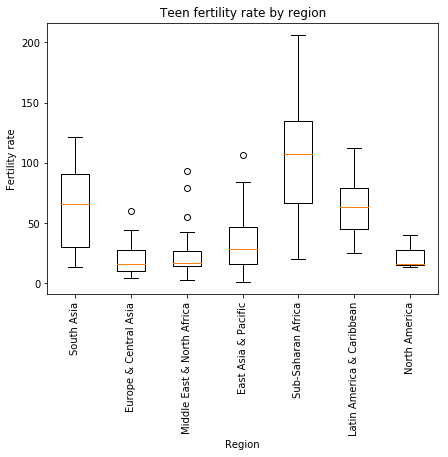

In [132]:
#Visualize regions as boxplots
regions_to_plot = [south_asia, europe_central_asia, middle_east_north_africa, east_asia_pacific, sub_saharan_africa, latin_america, north_america]

fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)

regions_box_plot = ax.boxplot(regions_to_plot, labels=regions)
plt.xticks(rotation='vertical')
plt.title('Teen fertility rate by region')
ax.set_ylabel('Fertility rate')
ax.set_xlabel('Region')

<strong>Findings:</strong>
The rate of births among teenage girls varies by region. Between 2005 and 2009, the highest rates on average were seen in Sub-Saharan African countries (average of 64 in 1,000 girls). The lowest rates on average were seen in European and Central Asian countries (average of 19 in 1,000 girls). Rates in North American and Middle Eastern or North African countries were also almost always low.

However, as seen in the box plot above, rates in Sub-Saharan Africa varied widely, and there are counties in this region which had lower fertility rates than some countries in other regions.

### How do teen fertility rates vary by country income?

In [133]:
#Look at teen fertility rate by region
latest_fertility.groupby(by='IncomeGroup')['fertility'].describe()

,count,mean,std,min,25%,50%,75%,max
IncomeGroup,,,,,,,,
High income,65.0,20.258801,16.015862,2.6,9.2000,15.0,26.5,63.28
Low income,29.0,109.186207,51.857936,1.0,67.0000,111.6,140.8,206.20
Lower middle income,50.0,62.338500,38.211699,5.6,30.0375,54.6,82.5,172.00
Upper middle income,56.0,48.648786,29.564810,3.0,22.3000,42.5,72.6,122.60


In [134]:
#Get the data by region. Assign to collections for use in boxplots
income_groups = list(latest_fertility['IncomeGroup'].unique())
income_groups

['Low income', 'Upper middle income', 'High income', 'Lower middle income']

In [135]:
#Create groups by income
low_income = latest_fertility[latest_fertility['IncomeGroup']==income_groups[0]]['fertility']
upper_middle_income = latest_fertility[latest_fertility['IncomeGroup']==income_groups[1]]['fertility']
high_income = latest_fertility[latest_fertility['IncomeGroup']==income_groups[2]]['fertility']
low_middle_income = latest_fertility[latest_fertility['IncomeGroup']==income_groups[3]]['fertility']

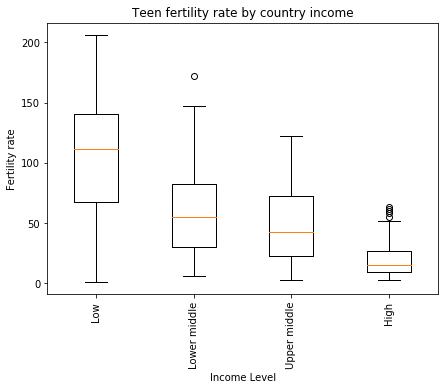

In [136]:
#Visualize regions as boxplots
income_groups_to_plot = [low_income, low_middle_income, upper_middle_income, high_income]

fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)

income_groups_box_plot = ax.boxplot(income_groups_to_plot, labels=['Low','Lower middle','Upper middle','High'])
plt.xticks(rotation='vertical')
plt.title('Teen fertility rate by country income')
ax.set_ylabel('Fertility rate')
ax.set_xlabel('Income Level')

<strong>Findings:</strong>
Between 2005 and 2009, the average rate of births among teenage girls also varied by country income level. The highest rates on average were seen in low income countries (average of 109 in 1,000 girls). The lowest rates on average were seen in high income countries (average of 16 in 1,000 girls). 

It should be noted that low fertility rates do exist among countries in each income group, and rates vary widely especially among low income countries. Even so, the the difference in fertility rates between the vast majority of low income countries and their high income counterparts is striking.

### Do countries with higher rates of teen fertility also tend to have lower literacy rates for girls?

In [137]:
#Correlation
latest_fert_lit.corr()

,fertility,female_literacy
fertility,1.000000,-0.691964
female_literacy,-0.691964,1.000000


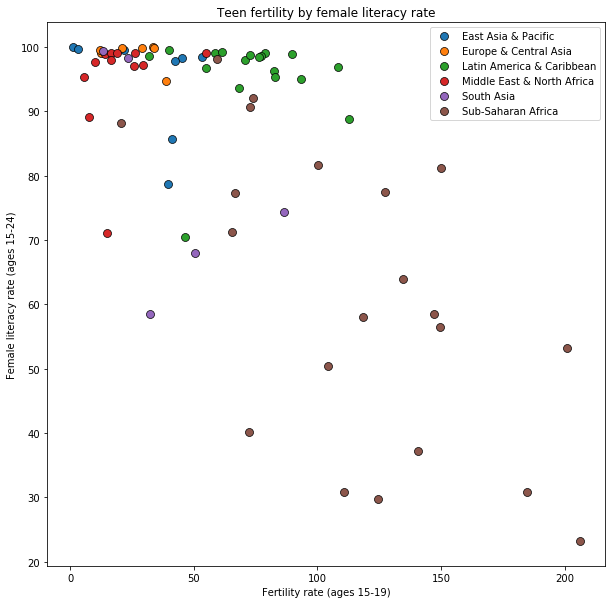

In [138]:
#Group by region
region_groups = latest_fert_lit.groupby('Region')

#Plot
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
for name, members in region_groups:
    ax.plot(members.fertility, 
            members.female_literacy, 
            marker='o',
            markeredgewidth = 0.7,
            markeredgecolor = 'black',
            linestyle='', 
            ms=8, 
            label=name)
plt.title('Teen fertility by female literacy rate')
ax.set_xlabel('Fertility rate (ages 15-19)')
ax.set_ylabel('Female literacy rate (ages 15-24)')
ax.legend()
ax.margins(0.05)

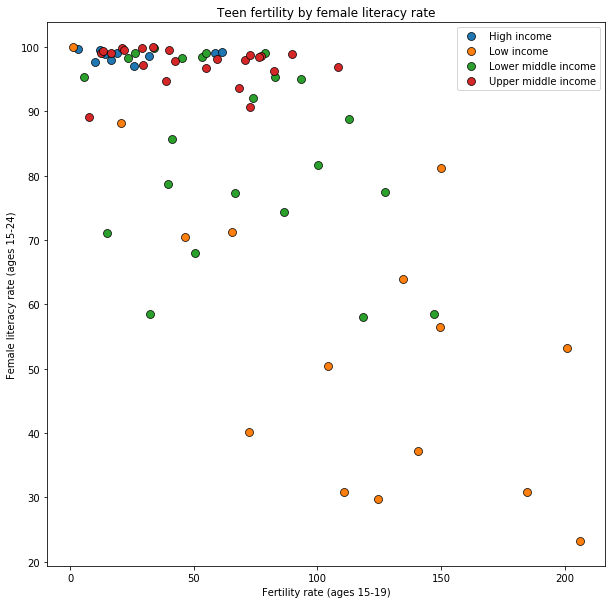

In [139]:
#Group by country income
income_groups = latest_fert_lit.groupby('IncomeGroup')

#Plot
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
for name, members in income_groups:
    ax.plot(members.fertility, 
            members.female_literacy, 
            marker='o',
            markeredgewidth = 0.7,
            markeredgecolor = 'black',
            linestyle='', 
            ms=8, 
            label=name)
plt.title('Teen fertility by female literacy rate')
ax.set_xlabel('Fertility rate (ages 15-19)')
ax.set_ylabel('Female literacy rate (ages 15-24)')
ax.legend()
ax.margins(0.05)

<strong>Findings:</strong>
The above analyses and charts compare average fertility rates and average literacy rates for countries between 2005 and 2009.
Pearson correlation coefficients show a modest negative correlation (=0.69) between the two. In other words, countries with higher literacy rates for females (ages 15-24) tend to have lower rates of births for teenage girls (ages 15-19). To what degree one influences the other (if at all), and in which direction, is not clear.

The scatter plots above reveal that the higher fertility rates and lower literacy rates are largely in Sub-Saharan Africa, but noteably many Latin American countries have very high literacy rates but tend to have higher fertility rates than most other regions. And, it is important to note that some Sub-Saharan African countries have high fertility rates despite fairly high literacy rates, and others the opposite.

The scatter plot colored by country income group also shows that low income countries tend to have high fertility rates and lower literacy rates. Many of the countries with lower literacy rates and higher fertility rates are also lower middle income countries. And, some uppper middle income countries--those in Latin America-- have somewhat higher fertility rates despite having high literacy rates.

### Do countries with higher rates of teen fertility also tend to have lower school completion rates for girls?

In [140]:
#Correlation
latest_fert_sch.corr()

,fertility,school_completion
fertility,1.000000,-0.667032
school_completion,-0.667032,1.000000


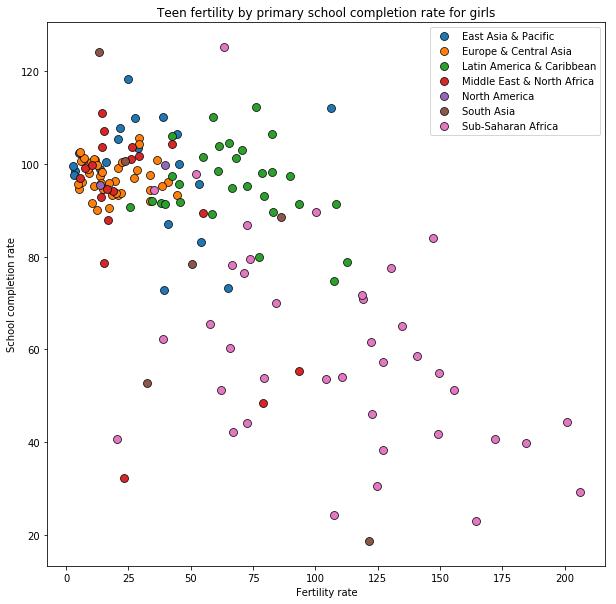

In [141]:
#Group by region
region_groups = latest_fert_sch.groupby('Region')

#Plot
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
for name, members in region_groups:
    ax.plot(members.fertility, 
            members.school_completion, 
            marker='o',
            markeredgewidth = 0.7,
            markeredgecolor = 'black',
            linestyle='', 
            ms=8, 
            label=name)
plt.title('Teen fertility by primary school completion rate for girls')
ax.set_xlabel('Fertility rate')
ax.set_ylabel('School completion rate')
ax.legend()
ax.margins(0.05)

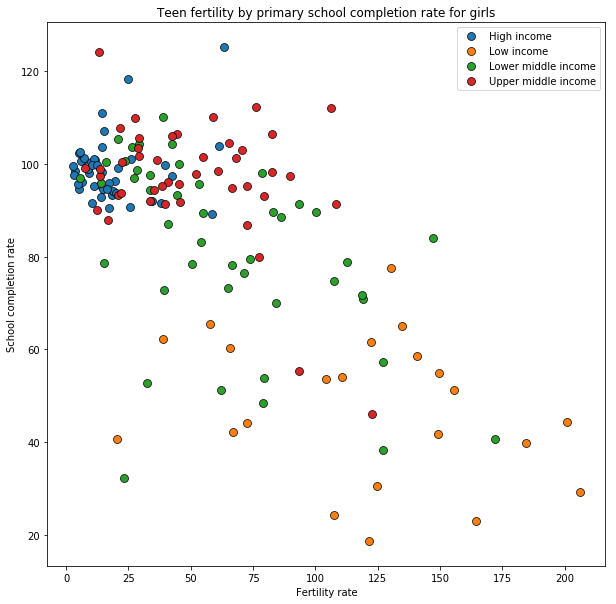

In [142]:
#Group by country income
income_groups = latest_fert_sch.groupby('IncomeGroup')

#Plot
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111)
for name, members in income_groups:
    ax.plot(members.fertility, 
            members.school_completion, 
            marker='o',
            markeredgewidth = 0.7,
            markeredgecolor = 'black',
            linestyle='', 
            ms=8, 
            label=name)
plt.title('Teen fertility by primary school completion rate for girls')
ax.set_xlabel('Fertility rate')
ax.set_ylabel('School completion rate')
ax.legend()
ax.margins(0.05)

<strong>Findings:</strong>
From the correlations, it is clear that literacy rates and primary school completion rates (the percent of the relevant age group finishing primary school*) are well correlated (with a coefficient of .86). However, school completion rates and fertility rates correlate more modestly (-0.67) and similar to literary rates. Again, Sub-Saharan African countries and low income countries are clearly represented as tending to have higher fertility rates and lower school completion rates. Upper middle income countries and Latin American countries have high rates of primary school completion but somewhat higher rates of fertility than do higher income countries and several other regions. That fertility rates are somewhat higher in these countries despite higher country incomes and educational achievement suggests other factors are at play than those considered here.

*A note on rates From the data source, "The ratio can exceed 100% due to over-aged and under-aged children who enter primary school late/early and/or repeat grades".

### Finally, how have teen fertility rates changed over time? Where are they increasing?

In [143]:
#See which countries saw an increase or decrease since the late 1970s, 1980s, or 1990s
#Note that if either the more recent or prior timeframe has a missing value, the subtraction will return a missing value.

fert_new = fertility_pivot_filtered.copy()
   
fert_new.loc[:,'change_from_70s'] = fertility_pivot_filtered.loc[:,'avg_2005_2009'] - fertility_pivot_filtered.loc[:,'avg_1975_1979']
fert_new.loc[:,'change_from_80s'] = fertility_pivot_filtered.loc[:,'avg_2005_2009'] - fertility_pivot_filtered.loc[:,'avg_1985_1989']
fert_new.loc[:,'change_from_90s'] = fertility_pivot_filtered.loc[:,'avg_2005_2009'] - fertility_pivot_filtered.loc[:,'avg_1995_1999']
fert_new.head(3)

,country,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009,Region,IncomeGroup,change_from_70s,change_from_80s,change_from_90s
0,Afghanistan,NaN,NaN,NaN,NaN,202.00,162.20,121.60,South Asia,Low income,NaN,NaN,-80.4
1,Albania,NaN,NaN,NaN,16.96,21.54,15.45,12.54,Europe & Central Asia,Upper middle income,NaN,NaN,-9.0
2,Algeria,97.02,47.83,33.0,26.00,11.00,8.80,7.40,Middle East & North Africa,Upper middle income,-89.62,-25.6,-3.6


In [144]:
#Count increasers, decreasers, and unknowns between the most recent five year period (late 2000's) and prior decades

fert_new.loc[:,'change_from_70s_bool'] = ''
fert_new.loc[:,'change_from_80s_bool'] = ''
fert_new.loc[:,'change_from_90s_bool'] = ''

#https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
conditions1 = [(fert_new['change_from_70s'] < 0), (fert_new['change_from_70s'] >= 0)]
conditions2 = [(fert_new['change_from_80s'] < 0), (fert_new['change_from_80s'] >= 0)]
conditions3 = [(fert_new['change_from_90s'] < 0), (fert_new['change_from_90s'] >= 0)]
choices = ['Decreased','Increased or same']

fert_new['change_from_70s_bool'] = np.select(conditions1, choices, default = 'Unknown')
fert_new['change_from_80s_bool'] = np.select(conditions2, choices, default = 'Unknown')
fert_new['change_from_90s_bool'] = np.select(conditions3, choices, default = 'Unknown')

fert_new.head(3)

,country,avg_1975_1979,avg_1980_1984,avg_1985_1989,avg_1990_1994,avg_1995_1999,avg_2000_2004,avg_2005_2009,Region,IncomeGroup,change_from_70s,change_from_80s,change_from_90s,change_from_70s_bool,change_from_80s_bool,change_from_90s_bool
0,Afghanistan,NaN,NaN,NaN,NaN,202.00,162.20,121.60,South Asia,Low income,NaN,NaN,-80.4,Unknown,Unknown,Decreased
1,Albania,NaN,NaN,NaN,16.96,21.54,15.45,12.54,Europe & Central Asia,Upper middle income,NaN,NaN,-9.0,Unknown,Unknown,Decreased
2,Algeria,97.02,47.83,33.0,26.00,11.00,8.80,7.40,Middle East & North Africa,Upper middle income,-89.62,-25.6,-3.6,Decreased,Decreased,Decreased


In [145]:
#The clean dataframe with no missing values, only 'Increased or same', 'Decreased', or 'Unknown'
fert_new_clean = fert_new.loc[:,['Region','change_from_70s_bool','change_from_80s_bool','change_from_90s_bool']]
fert_new_clean.head(10)

,Region,change_from_70s_bool,change_from_80s_bool,change_from_90s_bool
0,South Asia,Unknown,Unknown,Decreased
1,Europe & Central Asia,Unknown,Unknown,Decreased
2,Middle East & North Africa,Decreased,Decreased,Decreased
3,East Asia & Pacific,Unknown,Unknown,Decreased
4,Europe & Central Asia,Unknown,Unknown,Unknown
5,Sub-Saharan Africa,Unknown,Unknown,Decreased
7,Latin America & Caribbean,Decreased,Unknown,Increased or same
8,Europe & Central Asia,Unknown,Unknown,Decreased
9,Latin America & Caribbean,Unknown,Unknown,Decreased
10,East Asia & Pacific,Decreased,Decreased,Decreased


In [146]:
fert_new_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 211
Data columns (total 4 columns):
Region                  200 non-null object
change_from_70s_bool    200 non-null object
change_from_80s_bool    200 non-null object
change_from_90s_bool    200 non-null object
dtypes: object(4)
memory usage: 7.8+ KB


In [147]:
#Changes from late 1970s
fert_from_70s = fert_new_clean.loc[:,['Region', 'change_from_70s_bool']]
fert_from_70s.pivot_table(index=['Region'], columns=['change_from_70s_bool'], aggfunc=len).fillna(0)

change_from_70s_bool,Decreased,Increased or same,Unknown
Region,,,
East Asia & Pacific,5.0,2.0,29.0
Europe & Central Asia,28.0,0.0,24.0
Latin America & Caribbean,19.0,1.0,16.0
Middle East & North Africa,1.0,1.0,18.0
North America,1.0,0.0,2.0
South Asia,1.0,0.0,7.0
Sub-Saharan Africa,3.0,0.0,42.0


In [148]:
#Changes from late 1980s
fert_from_80s = fert_new_clean.loc[:,['Region', 'change_from_80s_bool']]
fert_from_80s.pivot_table(index=['Region'], columns=['change_from_80s_bool'], aggfunc=len).fillna(0)

change_from_80s_bool,Decreased,Increased or same,Unknown
Region,,,
East Asia & Pacific,3.0,1.0,32.0
Europe & Central Asia,28.0,1.0,23.0
Latin America & Caribbean,0.0,0.0,36.0
Middle East & North Africa,1.0,1.0,18.0
North America,2.0,0.0,1.0
South Asia,1.0,0.0,7.0
Sub-Saharan Africa,3.0,0.0,42.0


In [149]:
#Changes from late 1990s
fert_from_90s = fert_new_clean.loc[:,['Region', 'change_from_90s_bool']]
fert_from_90s.pivot_table(index=['Region'], columns=['change_from_90s_bool'], aggfunc=len).fillna(0)

change_from_90s_bool,Decreased,Increased or same,Unknown
Region,,,
East Asia & Pacific,31.0,5.0,0.0
Europe & Central Asia,47.0,4.0,1.0
Latin America & Caribbean,33.0,1.0,2.0
Middle East & North Africa,18.0,2.0,0.0
North America,3.0,0.0,0.0
South Asia,8.0,0.0,0.0
Sub-Saharan Africa,42.0,3.0,0.0


<strong>Findings:</strong>
The three tables above show the number of countries in which the fertility rate among teenage girls decreased or stayed the same between the most recent five year period of data (2005 to 2009) and the decades prior, specifically compared to 1975 to 1979, 1985 to 1989, and 1995 to 1999. As seen in the "Unknown" columns, the number of countries for which a comparison can be made to prior decades is limited for the 70s and 80s, while most countries had data available at some point in the late 90s for comparison. 

Unfortunately, compared to 1995 to 1999, an increase in the average fertility rate was seen in 5 countries in East Asia or the Pacific, 4 countries in Europe or Central Africa, 3 in Sub-Saharan Africa, 2 in the Middle East or North Africa, and 1 in Latin America or the Caribbean. However, in all comparisons, the vast majority of countries have seen decreases in the average fertility rate. 

<br>
<br>
<br>

<a id='limitations'></a>
## Limitations

Some limitations of this analysis have been noted throughout the steps above. Each dataset, being from different sources, has its own preparation methodologies and limitations. The primary dataset, for example, was compiled by GapMinder from diverse data sources, and no attempt was made to verify the accuracy or thoroughness of that preparation. That this dataset was not updated since approximately 2011 also limited the analysis that could be conducted, even as other datasets have more recent data available. Furthermore, some countries were excluded from some or all analyses on account of missing data. Five year averages allowed for more countries to be included in the analyses, but over-time analysis possibilities were severely limited.

<br>
<br>
<br>

<a id='conclusions'></a>
## Conclusion

The number of births per 1,000 girls ages 15 to 19 (fertility rate) has been decreasing across almost all countries over the past few decades. However, many countries still see high rates (at least according to the latest available data from before 2010). Rates vary widely, however, even among countries with similar incomes and in similar regions. Even so, rates are generally much higher in Sub-Saharan Africa and low-income countries than they are in North American or European countries or among higher-income countries.

Fertility rates appear to be modestly correlated with literacy rates for females aged 15 to 24 as well as with girls' primary school completion. Countries with higher rates of teen fertility tend to have lower rates of literacy and school completion. These also tend to be lower or lower-middle income countries in Sub-Saharan Africa. It is not clear to what degree fertility impacts or is impacted by educational achievement, or whether each of these is likewise impacted by other other geographic or economic factors.

Variations between countries should be explored further. For example, why do Latin American countries tend to have high rates of educational achievement but also somewhat higher fertility rates than most other regions? Why do some low income and Sub-Saharan African countries see relatively low rates of fertility compared to the rest of the region? Finally, more data is needed to determine to what degree lower literacy and school completion rates impact, or on the other hand result from, a teen having a baby.